In [1]:
# libraries

using LinearAlgebra
using Random
using RandomMatrices
using StatsBase
using Statistics
using Plots

# 6.1. Linear regression

Let $A\in\mathbb{R}^{m\times n}, b\in\mathbb{R}^m$ and $F(x) = \frac{1}{2m}\|Ax - b\|_2^2$, where $x^\star\sim N(0, I_n)\in\mathbb{R}^n$ and $b = Ax^\star + \sigma v$ for $v\sim N(0, I_m)$. $\sigma = 0$ for noiseless experiments and $\sigma = \frac{1}{2}$ otherwise.

$A$ is generated as $A = QD$, where $Q\in\mathbb{R}^{m\times n}$ has uniformly random orthogonal columns, and $D = \text{diag}(1, 1 + (\kappa - 1)/(n - 1), \cdots, \kappa)$ is a diagonal matrix with linearly spaced entries between $1$ and a desired condition number $\kappa\geq1$.

In [2]:
# sample generation

function matrix_gen(
    m  :: Int,
    n  :: Int,
    σ :: Real, # noise?
    κ :: Real  # condition number
    )
    # generate b = Ax + σv where cond(A) = κ

    x_opt = randn(n)

    v = randn(m)
    
    Q = rand(Haar(1), m)[:, 1:n] # uniformly random orthogonal columns

    D = Diagonal(diagm(collect(range(1, κ; length = n))))

    A = Q * D

    b1 = A * x_opt
    
    b2 = b1 + σ * v
    
    return A, b1, b2, x_opt
    
end

# matrix_gen(1000, 40, 0, 1)

matrix_gen (generic function with 1 method)

## Figure 2 (a)

$m = 1000, n = 40, \kappa(A) = 1, \sigma = 0$.

In [3]:
# Generate data, define the objective function, and set parameters

Random.seed!(123)

# without/with noise & condition number 1
X, y, y2, x = matrix_gen(1000, 40, 0.5, 1)

m, n = size(X)

# the objective function
function F(θ)
    norm(X*θ - y)^2 / 2 / m
end

function F2(θ)
    norm(X*θ - y2)^2 / 2 / m
end

# optimal value
Fstar = F(x)
Fstar2 = F2(x)

# parameter setting
T = 100 # # of experiments
K = 1e3 # total iterations
γinits = exp.(collect(range(log(10^(-2)), log(10^5), length = 15)))
ϵ = 0.05 # tolerance
β = 0.6 # exponent of step size

0.6

In [4]:
norm(X * 1.3*ones(n) - y2)^2/2/m

0.19082388531190048

In [5]:
Fstar

0.0

In [6]:
norm(X * 1.3*ones(n) - y)^2/2/m

0.05947867187955969

In [7]:
Fstar2

0.12700588981783822

In [8]:
# experiments for SGM (Figure 2 (a))

# initialization
iterations_SGM = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # SGM update
            θ = θ + (γ * (y[idx] - X[idx,:]'θ)) * X[idx,:]
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_SGM[j, i] = k
                break
            end
        end
    end
end

In [9]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  327.55   486.5   673.3 
   12.0     42.5    79.0 
    3.0      9.0    20.05
    9.95    21.0    59.2 
  105.95   203.0   354.5 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 

In [10]:
# experiments for the truncated model (Figure 2 (a))

# initialization
iterations_truncated = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the truncated model
            θ = θ -  min(γ, 0.5*norm(y[idx] - X[idx,:]'θ)^2/norm((y[idx] - X[idx,:]'θ)*X[idx,:])^2)*(X[idx,:]'θ-y[idx])*X[idx,:]
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_truncated[j, i] = k
                break
            end
        end
    end
end

In [11]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  298.8    506.5   702.2 
   13.9     46.5    79.45
    5.0     11.5    22.05
    4.0     10.0    17.05
    4.95    10.0    17.0 
    4.95    11.0    20.05
    4.0     10.5    17.05
    5.0     10.0    16.1 
    4.0     10.0    16.05
    4.95    10.0    20.0 

In [12]:
# experiments for the proximal model (Figure 2 (a))

# initialization
iterations_proximal = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the proximal model
            θ = (γ*I - (γ^2/(1 + γ*X[idx,:]'X[idx,:]))*X[idx,:]*X[idx,:]')*(X[idx,:]*y[idx] + 1/γ*θ)
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_proximal[j, i] = k
                break
            end
        end
    end
end

In [13]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  365.0    509.5   681.05
   26.95    50.5    91.1 
    4.95    14.5    28.15
    4.0      9.0    15.05
    4.0      8.0    15.05
    3.0      7.0    15.05
    3.0      8.0    13.05
    3.0      8.0    16.0 
    2.0      8.0    14.05
    3.95     8.0    13.1 

In [14]:
# experiments for the bundle model (Figure 2 (a))

# initialization
iterations_bundle = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the bundle model
            fθ = 0.5sum(abs2, X[idx,:]'θ-y[idx])
            ∇fθ = X[idx,:]*(X[idx,:]'θ-y[idx])
            θy = θ - γ*∇fθ
            fθy = 0.5sum(abs2, X[idx,:]'θy-y[idx])
            ∇fθy = X[idx,:]*(X[idx,:]'θy-y[idx])
            θ̄ = θ - γ*∇fθy
            if fθ + ∇fθ'*(θ̄-θ) <= fθy + ∇fθy'*(θ̄-θy)
                θ = θ̄
            else
                λ = (fθy-fθ+γ*sum(abs2,∇fθ))/(γ*sum(abs2,∇fθy-∇fθ))
                θ -= γ*( (1-λ)*∇fθ + λ*∇fθy  )
            end
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_bundle[j, i] = k
                break
            end
        end
    end
end

In [15]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  319.0    533.5   676.0 
   23.95    55.5   101.1 
    5.0     16.0    32.05
    4.0     10.0    19.05
   20.0     46.0   115.75
  329.3    485.5   644.85
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 

In [16]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 2. (a)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond])
a = Shape([γinits; γinits[end:-1:2]],
    [sgm_iters[:,1]; sgm_iters[:,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")

BoundsError: BoundsError: attempt to access 29-element Array{Float64,1} at index [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 1]]

## Figure 2 (b)

$m = 1000, n = 40, \kappa(A) = 1, \sigma = \dfrac{1}{2}$.

In [17]:
# experiments for SGM (Figure 2 (b))

# initialization
iterations_SGM = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # SGM update
            θ = θ + (γ * (y2[idx] - X[idx,:]'θ)) * X[idx,:]
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F2(θ))
                iterations_SGM[j, i] = k
                break
            end
        end
    end
end

In [18]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  617.9    965.0  1000.0 
   25.8     89.5   189.1 
   11.0     43.0   106.1 
   59.75   115.0   228.15
  231.95   323.5   494.2 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 

In [19]:
# experiments for the truncated model (Figure 2 (b))

# initialization
iterations_truncated = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the truncated model
            θ = θ -  min(γ, 0.5*norm(y2[idx] - X[idx,:]'θ)^2/norm((y2[idx] - X[idx,:]'θ)*X[idx,:])^2)*(X[idx,:]'θ-y2[idx])*X[idx,:]
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F2(θ))
                iterations_truncated[j, i] = k
                break
            end
        end
    end
end

In [20]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  580.9    935.5  1000.0 
   33.85   100.0   195.4 
    8.0     29.0    78.25
    7.95    25.0    75.1 
    7.0     28.5    80.05
    9.9     29.0    77.1 
    9.0     28.5    90.1 
    5.95    23.0    96.05
    7.9     26.5    95.2 
    8.0     24.5    74.3 

In [21]:
# experiments for the proximal model (Figure 2 (b))

# initialization
iterations_proximal = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the proximal model
            θ = (γ*I - (γ^2/(1 + γ*X[idx,:]'X[idx,:]))*X[idx,:]*X[idx,:]')*(X[idx,:]*y2[idx] + 1/γ*θ)
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F2(θ))
                iterations_proximal[j, i] = k
                break
            end
        end
    end
end

In [22]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  609.5    957.0  1000.0 
   38.95   103.5   205.2 
    6.95    33.0    73.1 
    7.95    30.5    69.05
    8.0     64.0   133.25
   18.9    146.5   282.0 
   15.7    368.5   887.25
   40.5   1000.0  1000.0 
   12.85  1000.0  1000.0 
   16.7   1000.0  1000.0 

In [23]:
# experiments for the bundle model (Figure 2 (b))

# initialization
iterations_bundle = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the bundle model
            fθ = 0.5sum(abs2, X[idx,:]'θ-y2[idx])
            ∇fθ = X[idx,:]*(X[idx,:]'θ-y2[idx])
            θy = θ - γ*∇fθ
            fθy = 0.5sum(abs2, X[idx,:]'θy-y2[idx])
            ∇fθy = X[idx,:]*(X[idx,:]'θy-y2[idx])
            θ̄ = θ - γ*∇fθy
            if fθ + ∇fθ'*(θ̄-θ) <= fθy + ∇fθy'*(θ̄-θy)
                θ = θ̄
            else
                λ = (fθy-fθ+γ*sum(abs2,∇fθ))/(γ*sum(abs2,∇fθy-∇fθ))
                θ -= γ*( (1-λ)*∇fθ + λ*∇fθy  )
            end
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F2(θ))
                iterations_bundle[j, i] = k
                break
            end
        end
    end
end

In [24]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  621.95   987.5  1000.0 
   39.0     97.0   185.25
   11.0     34.0    76.0 
   17.0     56.0   139.0 
  102.9    172.0   272.15
  423.85   614.0   858.3 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 

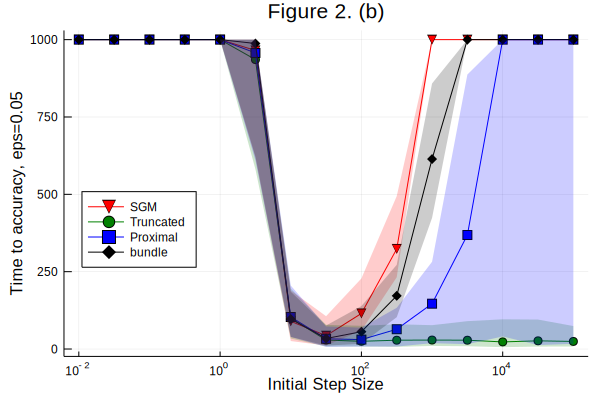

In [25]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 2. (b)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond])
a = Shape([γinits; γinits],
    [sgm_iters[:,1]; sgm_iters[:,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")

## Figure 3 (a)

$m = 1000, n = 40, \kappa(A) = 15, \sigma = 0$.

In [26]:
# Generate data, define the objective function, and set parameters

# without/with noise & condition number 1
X, y, y2, x = matrix_gen(1000, 40, 0.5, 15)

m, n = size(X)

# the objective function
function F(θ)
    norm(X*θ - y)^2 / 2 / m
end

function F2(θ)
    norm(X*θ - y2)^2 / 2 / m
end

# optimal value
Fstar = F(x)
Fstar2 = F2(x)

# parameter setting
T = 100 # # of experiments
K = 1e3 # total iterations
γinits = exp.(collect(range(log(10^(-2)), log(10^5), length = 15)))
ϵ = 0.05 # tolerance

0.05

In [27]:
# experiments for SGM (Figure 3 (a))

# initialization
iterations_SGM = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # SGM update
            θ = θ + (γ * (y[idx] - X[idx,:]'θ)) * X[idx,:]
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_SGM[j, i] = k
                break
            end
        end
    end
end

In [28]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
  503.95  1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0

In [29]:
# experiments for the truncated model (Figure 3 (a))

# initialization
iterations_truncated = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the truncated model
            θ = θ -  min(γ, 0.5*norm(y[idx] - X[idx,:]'θ)^2/norm((y[idx] - X[idx,:]'θ)*X[idx,:])^2)*(X[idx,:]'θ-y[idx])*X[idx,:]
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_truncated[j, i] = k
                break
            end
        end
    end
end

In [30]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  379.9    466.5   553.1 
  315.9    379.5   443.0 
  334.7    380.5   443.05
  322.75   383.0   440.05
  324.95   380.0   445.1 
  325.95   379.5   433.2 
  325.85   381.0   428.3 
  322.9    379.5   432.2 
  309.35   378.5   444.05
  321.8    377.0   433.45

In [31]:
# experiments for the proximal model (Figure 3 (a))

# initialization
iterations_proximal = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the proximal model
            θ = (γ*I - (γ^2/(1 + γ*X[idx,:]'X[idx,:]))*X[idx,:]*X[idx,:]')*(X[idx,:]*y[idx] + 1/γ*θ)
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_proximal[j, i] = k
                break
            end
        end
    end
end

In [32]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  491.7    602.0   721.1 
  250.95   320.0   378.0 
  215.95   262.5   321.2 
  202.85   263.5   320.05
  203.0    255.0   314.05
  206.9    255.0   317.15
  205.85   258.0   322.05
  203.0    251.0   306.25
  201.65   251.5   308.25
  212.9    259.0   314.0 

In [33]:
# experiments for the bundle model (Figure 3 (a))

# initialization
iterations_bundle = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the bundle model
            fθ = 0.5sum(abs2, X[idx,:]'θ-y[idx])
            ∇fθ = X[idx,:]*(X[idx,:]'θ-y[idx])
            θy = θ - γ*∇fθ
            fθy = 0.5sum(abs2, X[idx,:]'θy-y[idx])
            ∇fθy = X[idx,:]*(X[idx,:]'θy-y[idx])
            θ̄ = θ - γ*∇fθy
            if fθ + ∇fθ'*(θ̄-θ) <= fθy + ∇fθy'*(θ̄-θy)
                θ = θ̄
            else
                λ = (fθy-fθ+γ*sum(abs2,∇fθ))/(γ*sum(abs2,∇fθy-∇fθ))
                θ -= γ*( (1-λ)*∇fθ + λ*∇fθy  )
            end
            
            if (abs(F(θ) - Fstar) <= ϵ || k >= K)
                #println(F(θ))
                iterations_bundle[j, i] = k
                break
            end
        end
    end
end

In [34]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
  502.65   738.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0
 1000.0   1000.0  1000.0

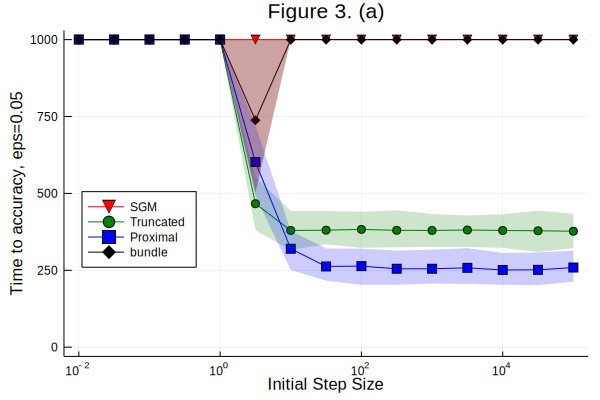

In [35]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 3. (a)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond],
    ylim = [0, 1000])
a = Shape([γinits; γinits],
    [sgm_iters[:,1]; sgm_iters[:,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")

## Figure 3 (b)

$m = 1000, n = 40, \kappa(A) = 15, \sigma = \dfrac{1}{2}$.

In [36]:
# experiments for SGM (Figure 3 (b))

# initialization
iterations_SGM = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # SGM update
            θ = θ + (γ * (y2[idx] - X[idx,:]'θ)) * X[idx,:]
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F(θ))
                iterations_SGM[j, i] = k
                break
            end
        end
    end
end

In [37]:
sgm_iters = [[quantile(iterations_SGM[:,i], 0.05) for i = 1:15] median(iterations_SGM, dims = 1)' [quantile(iterations_SGM[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
  561.7  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0

In [38]:
# experiments for the truncated model (Figure 3 (b))

# initialization
iterations_truncated = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the truncated model
            θ = θ -  min(γ, 0.5*norm(y2[idx] - X[idx,:]'θ)^2/norm((y2[idx] - X[idx,:]'θ)*X[idx,:])^2)*(X[idx,:]'θ-y2[idx])*X[idx,:]
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F(θ))
                iterations_truncated[j, i] = k
                break
            end
        end
    end
end

In [39]:
trunc_iters = [[quantile(iterations_truncated[:,i], 0.05) for i = 1:15] median(iterations_truncated, dims = 1)' [quantile(iterations_truncated[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  436.45   568.0   713.35
  427.4    560.5   771.6 
  424.9    537.0   697.35
  421.6    518.0   689.15
  408.85   538.5   721.45
  421.95   568.5   676.45
  419.35   541.5   733.35
  427.0    577.0   729.25
  401.75   554.0   746.1 
  414.65   544.5   744.25

In [40]:
# experiments for the proximal model (Figure 3 (b))

# initialization
iterations_proximal = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the proximal model
            θ = (γ*I - (γ^2/(1 + γ*X[idx,:]'X[idx,:]))*X[idx,:]*X[idx,:]')*(X[idx,:]*y2[idx] + 1/γ*θ)
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F(θ))
                iterations_proximal[j, i] = k
                break
            end
        end
    end
end

In [41]:
prox_iters = [[quantile(iterations_proximal[:,i], 0.05) for i = 1:15] median(iterations_proximal, dims = 1)' [quantile(iterations_proximal[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
 1000.0   1000.0  1000.0 
  546.0    663.0   843.2 
  338.25   467.0   587.35
  410.95   578.5   831.15
  472.85   825.5  1000.0 
  631.65  1000.0  1000.0 
  756.9   1000.0  1000.0 
  665.5   1000.0  1000.0 
  786.95  1000.0  1000.0 
  764.6   1000.0  1000.0 
  771.3   1000.0  1000.0 

In [42]:
# experiments for the bundle model (Figure 2 (b))

# initialization
iterations_bundle = zeros(T, 15)

# main iteration
for i = 1:15
    for j = 1:T
        γinit = γinits[i]
        θ = 1.3 * ones(n)
        for k = 1:K
            idx = sample(1:m) # sampling
            γ = γinit * k^(-β) # update stepsize
            
            # Update for the bundle model
            fθ = 0.5sum(abs2, X[idx,:]'θ-y2[idx])
            ∇fθ = X[idx,:]*(X[idx,:]'θ-y2[idx])
            θy = θ - γ*∇fθ
            fθy = 0.5sum(abs2, X[idx,:]'θy-y2[idx])
            ∇fθy = X[idx,:]*(X[idx,:]'θy-y2[idx])
            θ̄ = θ - γ*∇fθy
            if fθ + ∇fθ'*(θ̄-θ) <= fθy + ∇fθy'*(θ̄-θy)
                θ = θ̄
            else
                λ = (fθy-fθ+γ*sum(abs2,∇fθ))/(γ*sum(abs2,∇fθy-∇fθ))
                θ -= γ*( (1-λ)*∇fθ + λ*∇fθy  )
            end
            
            if (abs(F2(θ) - Fstar2) <= ϵ || k >= K)
                #println(F(θ))
                iterations_bundle[j, i] = k
                break
            end
        end
    end
end

In [43]:
bund_iters = [[quantile(iterations_bundle[:,i], 0.05) for i = 1:15] median(iterations_bundle, dims = 1)' [quantile(iterations_bundle[:,i], 0.95) for i = 1:15]]

15×3 Array{Float64,2}:
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
  642.0   814.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0
 1000.0  1000.0  1000.0

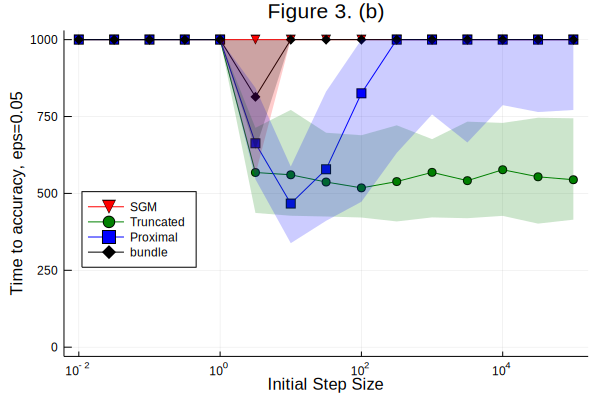

In [44]:
plt = plot(γinits, [sgm_iters[:,2] trunc_iters[:, 2] prox_iters[:, 2] bund_iters[:, 2]], 
    legend = :left,
    xscale = :log10,
    xlab = "Initial Step Size",
    ylab = "Time to accuracy, eps=0.05",
    title = "Figure 3. (b)",
    label = ["SGM" "Truncated" "Proximal" "bundle"],
    color = [:red :green :blue :black],
    markershape = [:dtriangle :circle :square :diamond],
    ylim = [0, 1000])
a = Shape([γinits; γinits],
    [sgm_iters[:,1]; sgm_iters[:,3]])
plot!(a, fillalpha = 0.2, linecolor = nothing, fillcolor = :red, label = "")
b = Shape([γinits; γinits[end:-1:2]],
    [trunc_iters[:,1]; trunc_iters[end:-1:2,3]])
plot!(b, fillalpha = 0.2, linecolor = nothing, fillcolor = :green, label = "")
c = Shape([γinits; γinits[end:-1:2]],
    [prox_iters[:,1]; prox_iters[end:-1:2,3]])
plot!(c, fillalpha = 0.2, linecolor = nothing, fillcolor = :blue, label = "")
d = Shape([γinits; γinits[end-1:-1:2]],
    [bund_iters[:,1]; bund_iters[end-1:-1:2,3]])
plot!(d, fillalpha = 0.2, linecolor = nothing, fillcolor = :black, label = "")